In [2]:
import skimage
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams
from statsmodels.stats.weightstats import ttest_ind
from statannotations.Annotator import Annotator
from math import floor
rcParams['figure.dpi'] = 250
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 10

In [10]:

data_dirs = {
    'DIV11' : 
    Path('/lab/processed-data/230303_iN_B5_DIV11_LiveCell/iN_B5_D11_LiveCell_20xH2O__2023-03-03T14_21_01-Measurement 1'),
    'DIV14' :
    Path('/lab/processed-data/230227_iN_B4_DIV14_LiveCell/1__2023-02-27T21_03_45-Measurement 4'),
    'DIV16_10x' : 
    Path('/lab/processed-data/230215_BC_Live/1__2023-02-15T17_25_23-Measurement 2'),
    'DIV16_63x' : 
    Path('/lab/processed-data/230215_BC_Live/2__2023-02-15T18_09_38-Measurement 1'),
    'DIV28' :
    Path('/lab/processed-data/230227_iN_B3_DIV28_LiveCell/1__2023-02-27T21_51_31-Measurement 5'),
    'DIV31' : 
    Path('/lab/processed-data/230302_iN_B3_DIV31_MG132_LiveCell/iN_B3_DIV31_MG132__2023-03-02T15_25_55-Measurement 1'),
    'DIV31_40x' : 
    Path('/lab/processed-data/230302_iN_B3_DIV31_MG132_LiveCell/iN_B3_DIV31_MG132_40xH2O__2023-03-02T16_07_40-Measurement 1'),
    'ALS0009 DIV18, 1':
    Path('/lab/processed-data/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18_1__2023-03-10T16_06_08-Measurement 1/'),
    'ALS0009 DIV18, 2':
    Path('/lab/processed-data/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18_2__2023-03-10T16_42_11-Measurement 2/'),
    'ALS0013 DIV11, 1' : 
    Path('/lab/processed-data/2023-03-10_LiveCell_20x_ALS0013_KO1_DIV11/2023-03-10_LiveCell_20x_ALS0013_KO1_DIV11_1__2023-03-10T12_17_48-Measurement 1'),
    'ALS0013 DIV11, 2' :
    Path('/lab/processed-data/2023-03-10_LiveCell_20x_ALS0013_KO1_DIV11/2023-03-10_LiveCell_20x_ALS0013_KO1_DIV11_1__2023-03-10T12_53_28-Measurement 2'),
    'ALS0009 DIV25' :
    Path('/lab/processed-data/LiveCell_ALS0009_NGN2_KO1_DIV25_20x_2023-03-17/LiveCell_ALS0009_NGN2_KO1_DIV25_20x_2023__2023-03-17T13_36_52-Measurement 1'),
    'ALS0013 DIV18' :
    Path('/lab/processed-data/LiveCell_ALS00013_NGN2_KO1_DIV18_20x_2023-03-17/LiveCell_ALS00013_NGN2_KO1_DIV18_20x_2023-03-17__2023-03-17T15_15_01-Measurement 1'),
    'ALS0014 DIV11' :
    Path('/lab/processed-data/LiveCell_ALS00014_NGN2_KO1_DIV11_20x_2023-03-17/LiveCell_ALS00014_NGN2_KO1_DIV11_20x_2023-03-17__2023-03-17T16_22_38-Measurement 1')
}

In [38]:
data_dir = data_dirs['ALS0009 DIV18, 2']

/tmp/ipykernel_2361/743947311.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
/tmp/ipykernel_2361/743947311.py:44: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_2361/743947311.py:44: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_2361/743947311.py:44: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_2361/743947311.py:44: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


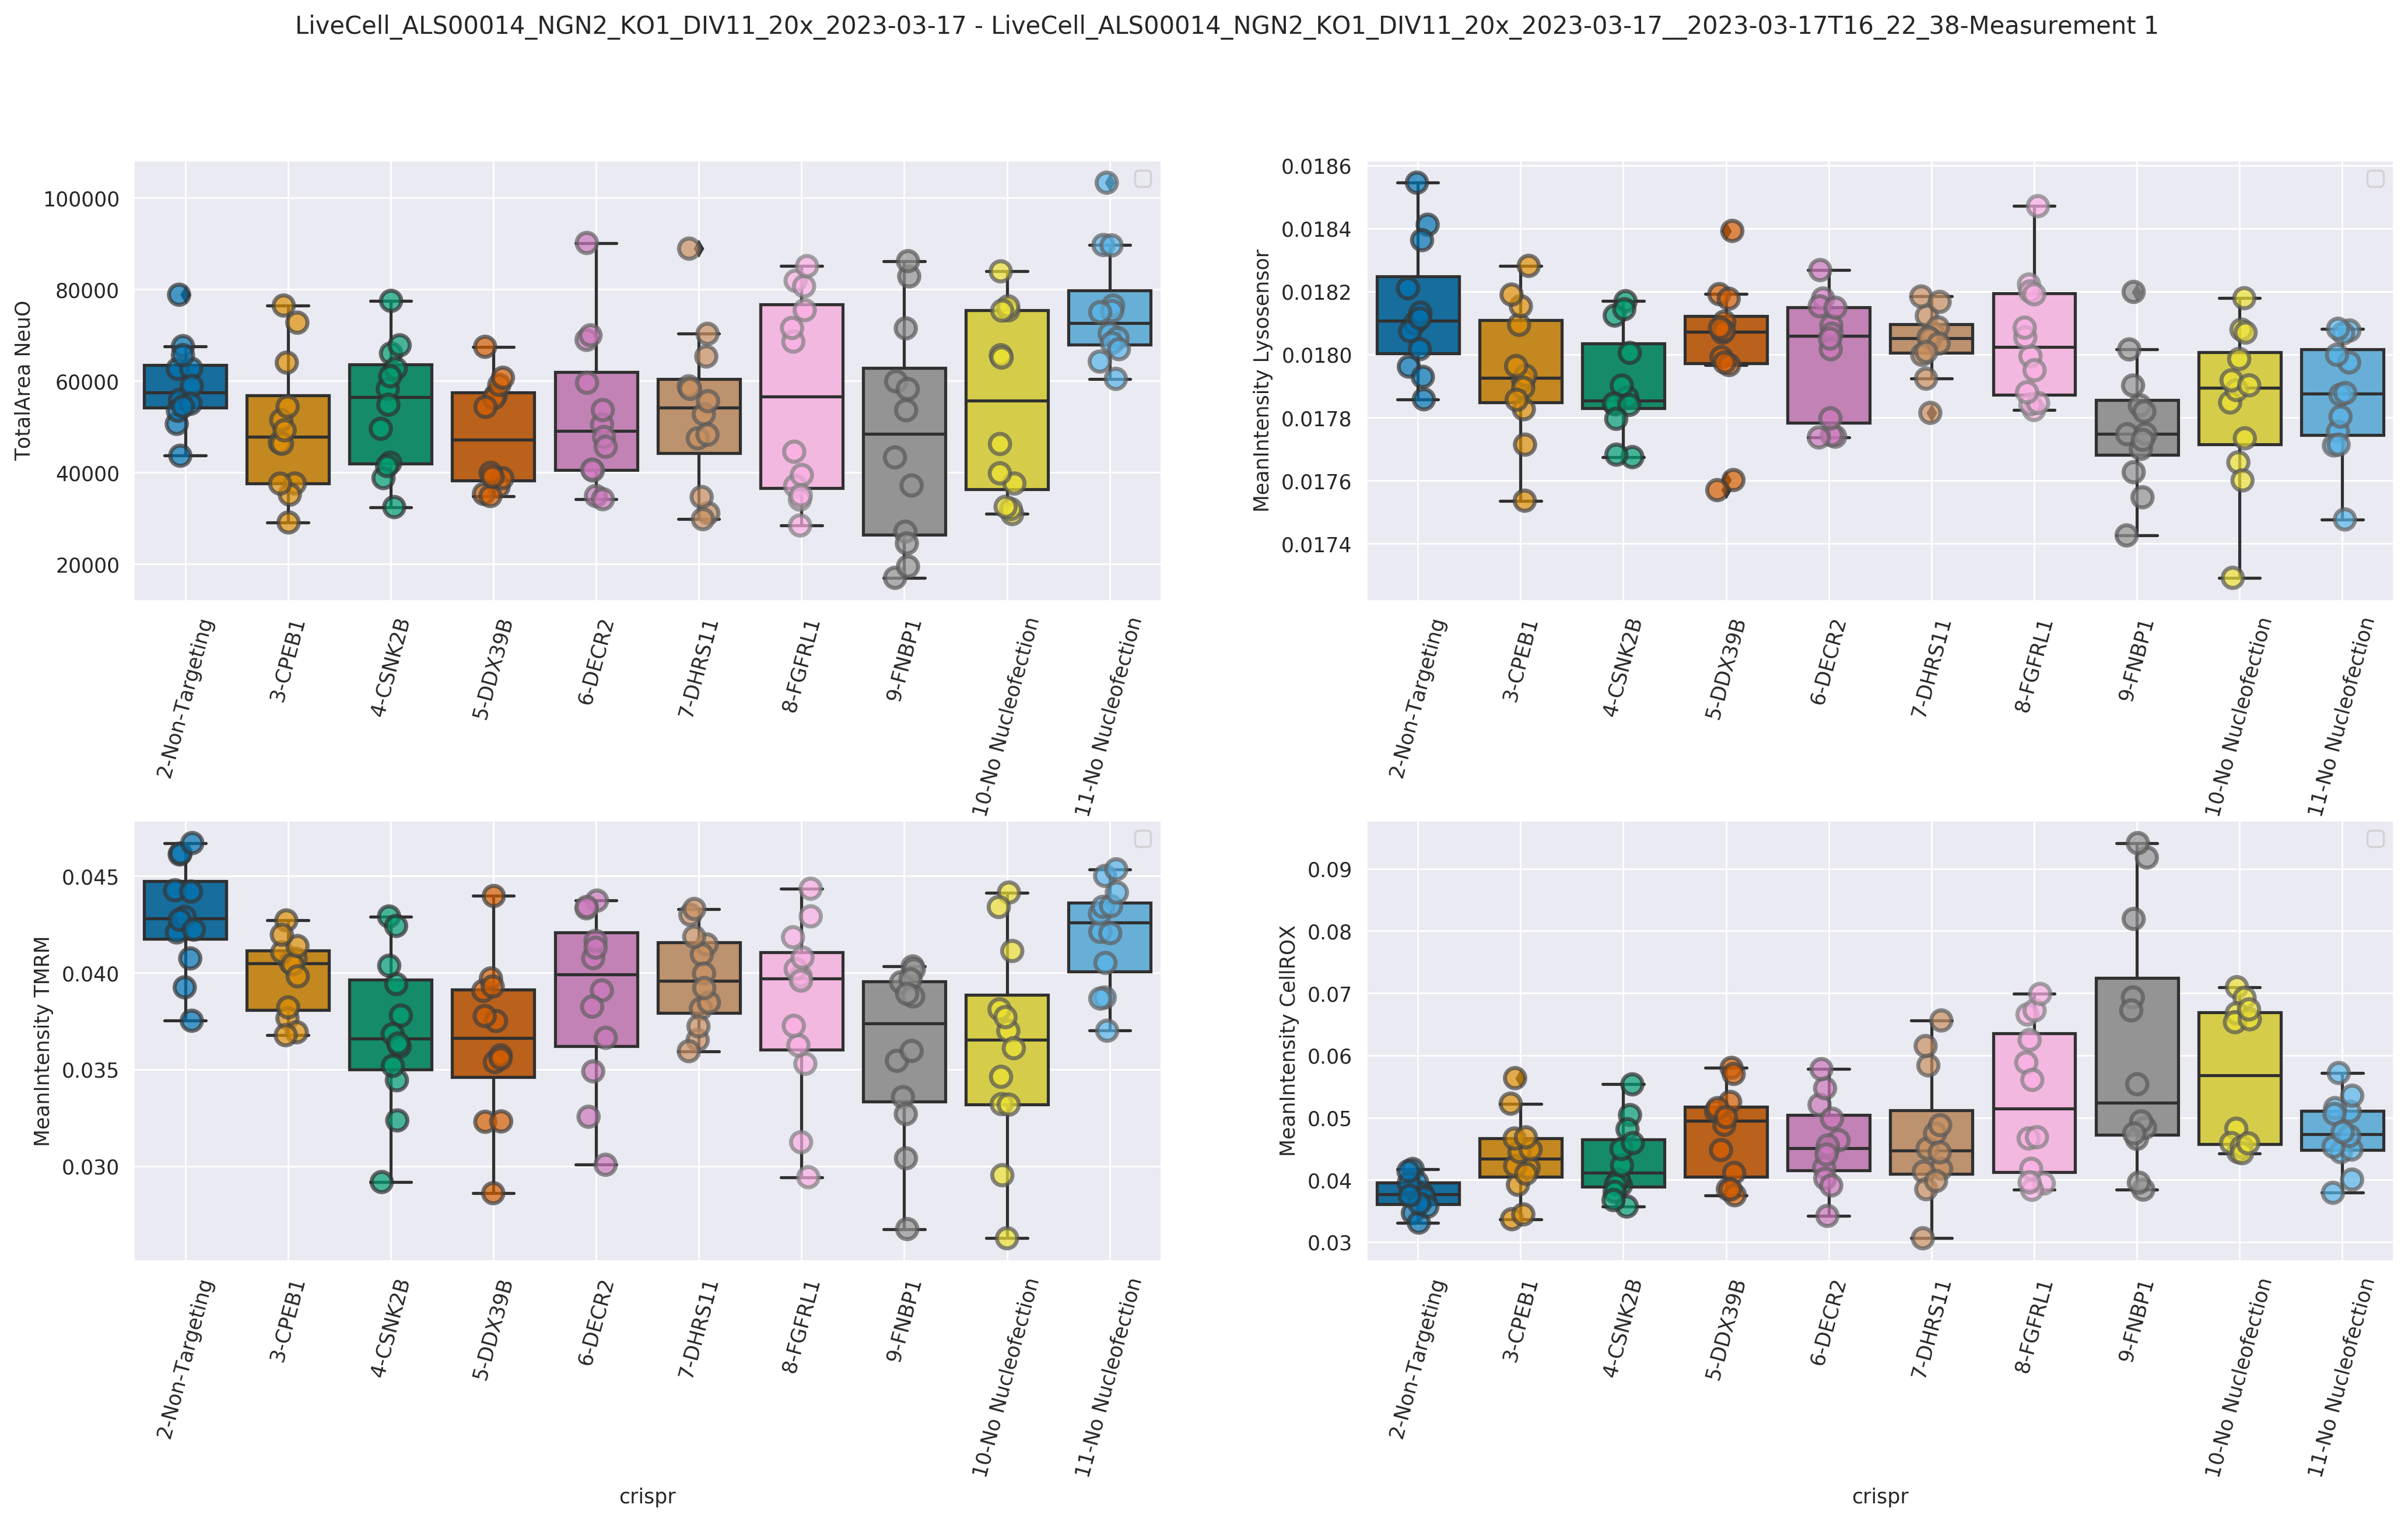

In [29]:
platemap = pd.read_csv(data_dir / 'platemap.csv')
data = pd.read_csv(data_dir / '2023-02-28_soma_segment' / '2023-02-28_soma_segment_Image.csv')

# Set filename and well position
data['well_position'] = data['FileName_NeuO_pre_illum'].apply(
    lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
)
data['row'] = data['FileName_NeuO_pre_illum'].apply(
lambda fname : int(fname[1:3])
)
data['col'] = data['FileName_NeuO_pre_illum'].apply(
    lambda fname : int(fname[4:6])
)

data = data.merge(platemap, on='well_position')
# data = data.groupby(['well_position', 'crispr']).mean()
data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
data = data.reset_index()
data['crispr'] = data['col'].astype(str) + '-' + data['crispr']
measurements = [
    'Intensity_TotalArea_NeuO_masked',
    'Intensity_MeanIntensity_Lysosensor_masked',
    'Intensity_MeanIntensity_TMRM_masked',
    'Intensity_MeanIntensity_CellROX_masked'
]

sns.set_style('darkgrid')
fig, axs = plt.subplots(2,2)

for i_m, m in enumerate(measurements):

    axs_row = floor(i_m/2)
    axs_col = i_m % 2

    sns.boxplot(
        data=data, 
        x='crispr', 
        # x='concentration',
        y=m, 
        palette='colorblind',
        # hue='crispr',
        ax=axs[axs_row, axs_col]
    )
    sns.stripplot(
        data=data, 
        x='crispr', 
        # x='concentration',
        y=m, 
        palette='colorblind', 
        # hue='crispr',
        # dodge=True,
        linewidth=2, 
        size=10, 
        alpha=0.7,
        ax=axs[axs_row, axs_col])
    
    axs[axs_row, axs_col].tick_params(axis='x', rotation=75)
    axs[axs_row, axs_col].set_ylabel(m.split('_')[1] + ' ' + m.split('_')[2])
    axs[axs_row, axs_col].xaxis.grid(True)
    axs[axs_row, axs_col].legend('')
    
plt.suptitle(data_dir.parents[0].name + ' - ' + data_dir.name)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

/tmp/ipykernel_3112/3042295127.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['well_position', 'row', 'col', 'crispr']).mean()


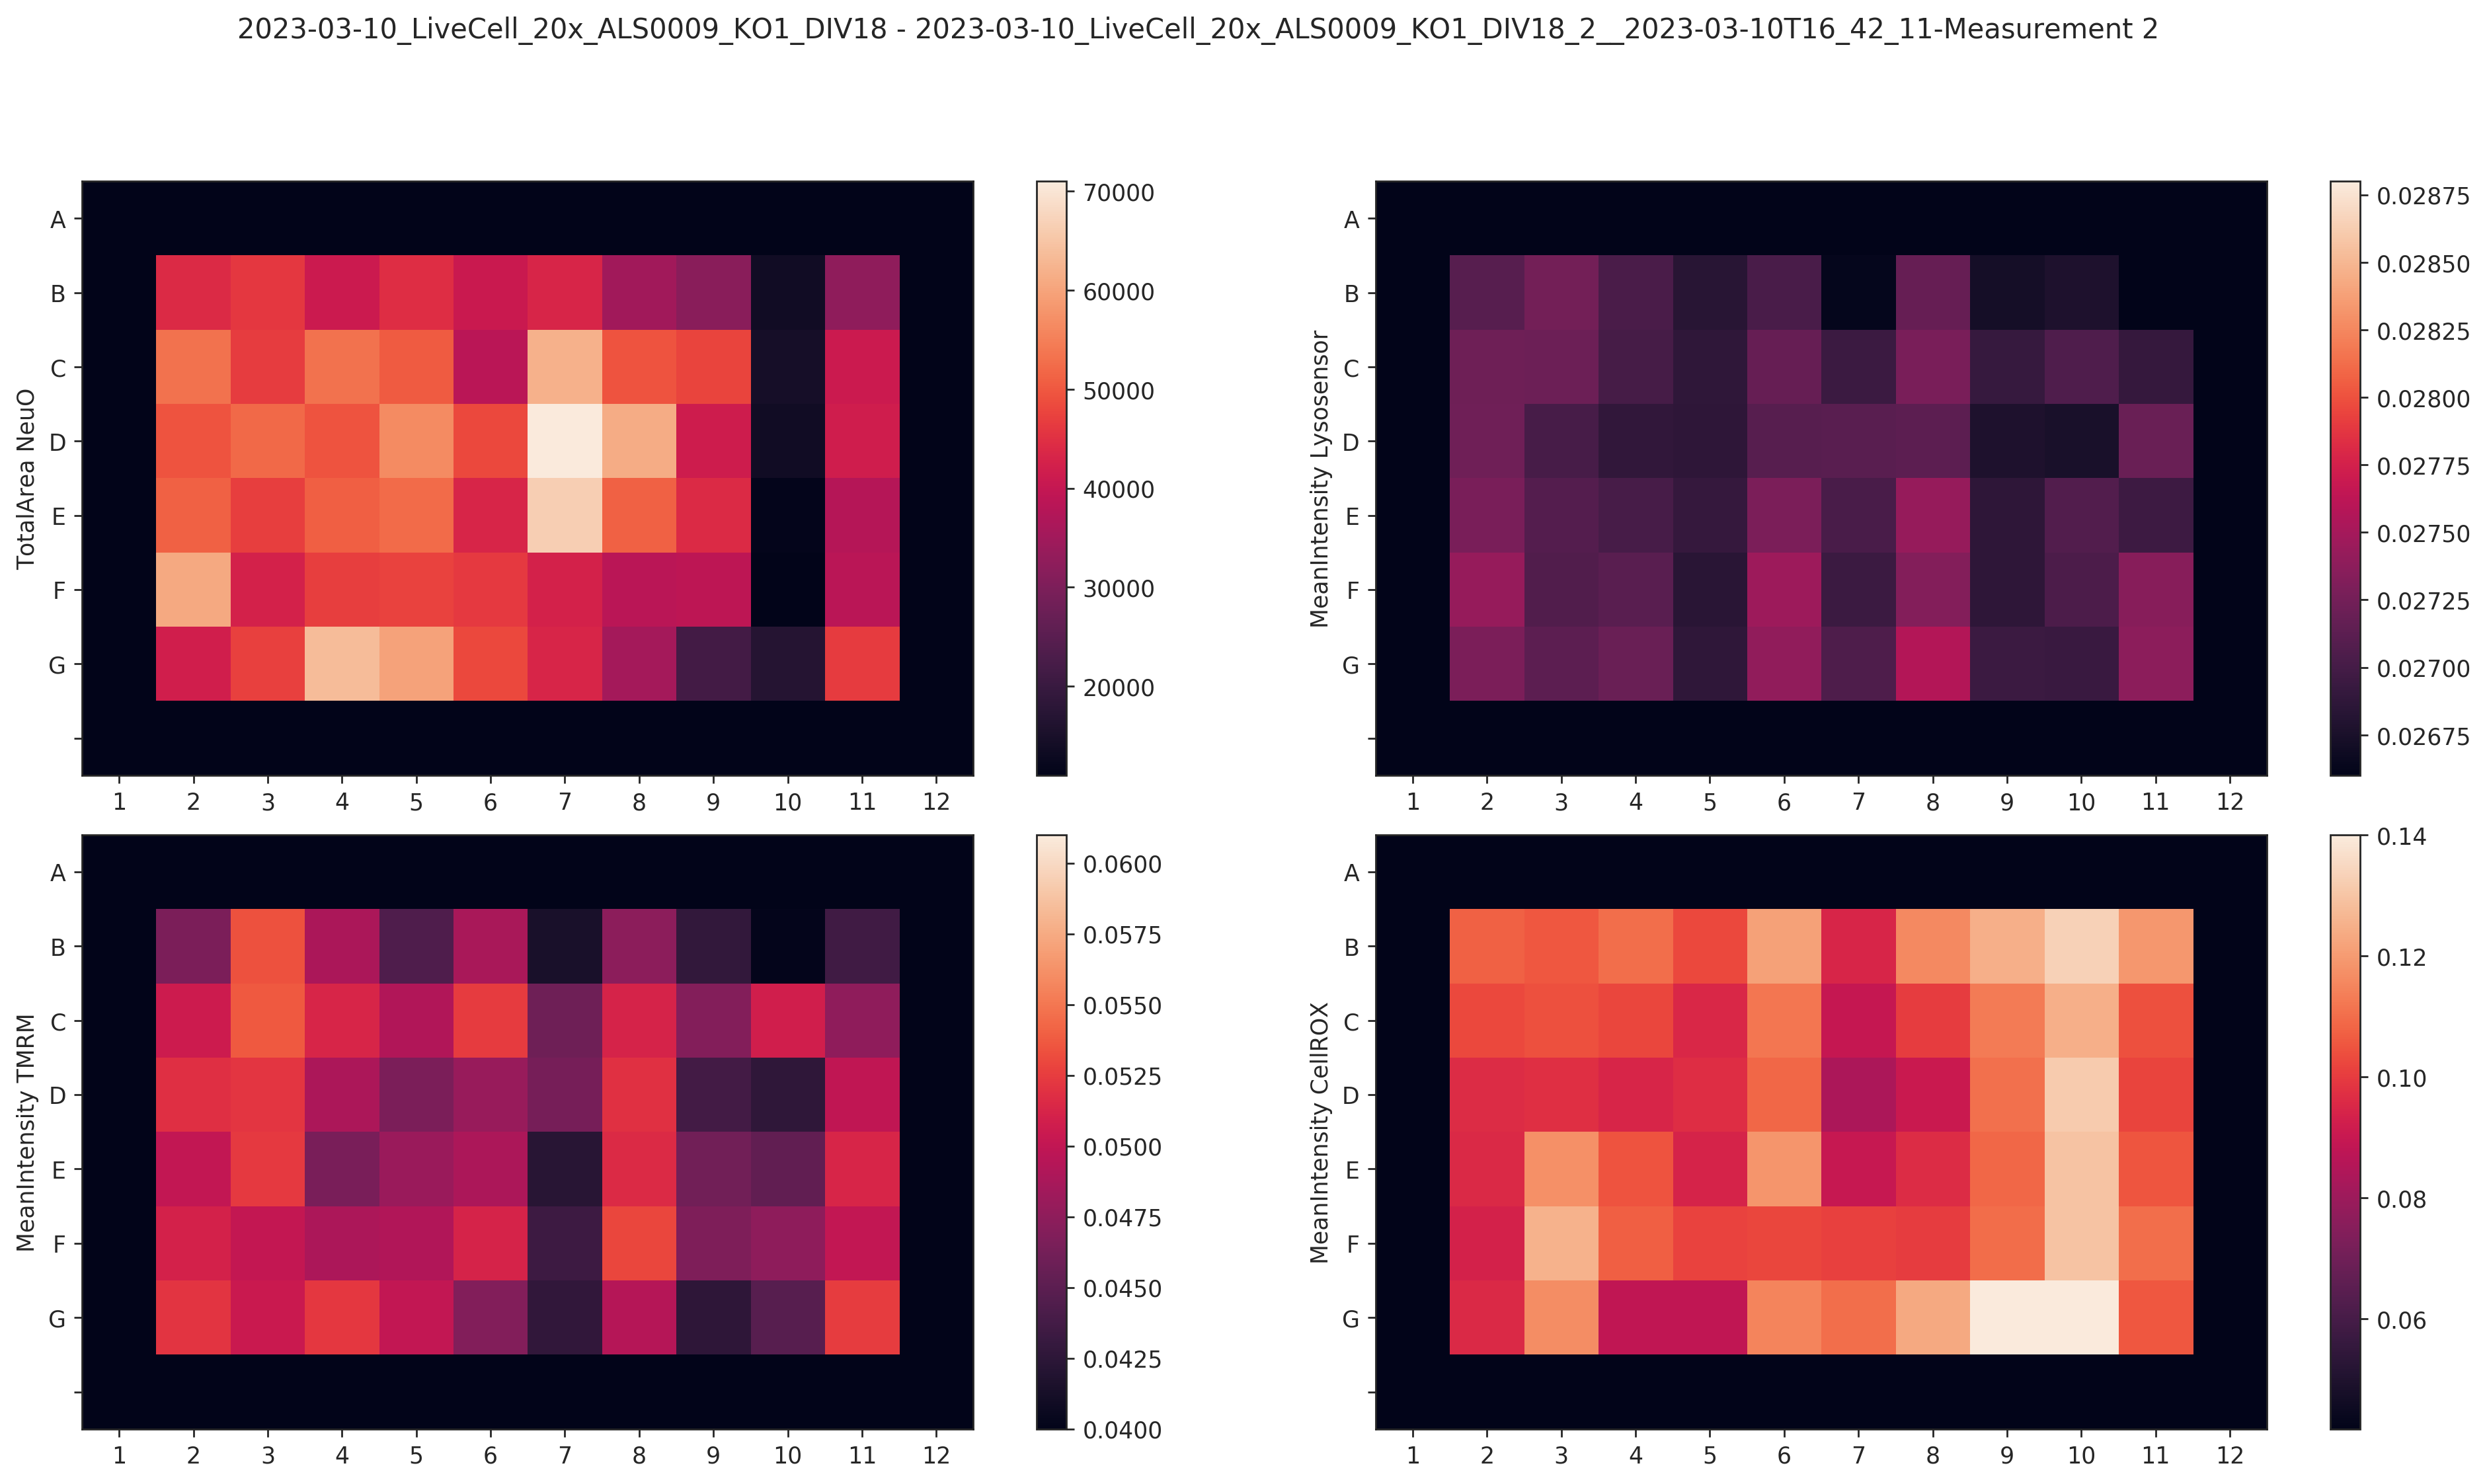

In [39]:
# data_dir = data_dirs['DIV16_10x']
platemap = pd.read_csv(data_dir / 'platemap.csv')
data = pd.read_csv(data_dir / '2023-02-28_soma_segment' / '2023-02-28_soma_segment_Image.csv')
filename = 'FileName_NeuO_pre_illum'

# Set filename and well position
data['well_position'] = data['FileName_NeuO_pre_illum'].apply(
    lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
)
# Set filename and well position
plate = np.zeros([8, 12])
data['well_position'] = data[filename].apply(
    lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
)
data['row'] = data[filename].apply(
    lambda fname : int(fname[1:3])
)
data['col'] = data[filename].apply(
    lambda fname : int(fname[4:6])
)
data = data.merge(platemap, on='well_position')
data = data.groupby(['well_position', 'row', 'col', 'crispr']).mean()
# data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'concentration']).mean()
data = data.reset_index()

measurements = [
    'Intensity_TotalArea_NeuO_masked',
    'Intensity_MeanIntensity_Lysosensor_masked',
    'Intensity_MeanIntensity_TMRM_masked',
    'Intensity_MeanIntensity_CellROX_masked'
]

sns.set_style('ticks')
fig, axs = plt.subplots(2,2)

measurement_vmax = [71e3, 0.0288, 0.061, 0.14]
measurement_vmin = [11e3, 0.0266, 0.04, 0.0418]
for i_m, m in enumerate(measurements):

    axs_row = floor(i_m/2)
    axs_col = i_m % 2

    plate[data['row']-1, data['col']-1] = data[m]
    vmin = plate[plate != plate.min()].min()
    # im = axs[axs_row, axs_col].imshow(plate, vmin=vmin)
    im = axs[axs_row, axs_col].imshow(plate, vmin=measurement_vmin[i_m], vmax=measurement_vmax[i_m])
    # print(vmin)
    axs[axs_row, axs_col].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    axs[axs_row, axs_col].set_xticklabels([1,2,3,4,5,6,7,8,9,10,11,12])
    axs[axs_row, axs_col].set_yticks([0,1,2,3,4,5,6,7])
    axs[axs_row, axs_col].set_yticklabels(['A','B','C','D','E','F','G'])
    plt.colorbar(im, ax=axs[axs_row, axs_col])
    # plt.title(data_dir.parents[0].name + ' - ' + data_dir.name)

    # axs[axs_row, axs_col].tick_params(axis='x', rotation=25)
    axs[axs_row, axs_col].set_ylabel(m.split('_')[1] + ' ' + m.split('_')[2])
    # axs[axs_row, axs_col].xaxis.grid(True)
    # axs[axs_row, axs_col].legend('')
    
plt.suptitle(data_dir.parents[0].name + ' - ' + data_dir.name)
plt.subplots_adjust(wspace=0.02, hspace=0.1)

/tmp/ipykernel_3112/3223848232.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
/tmp/ipykernel_3112/3223848232.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
/tmp/ipykernel_3112/3223848232.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which

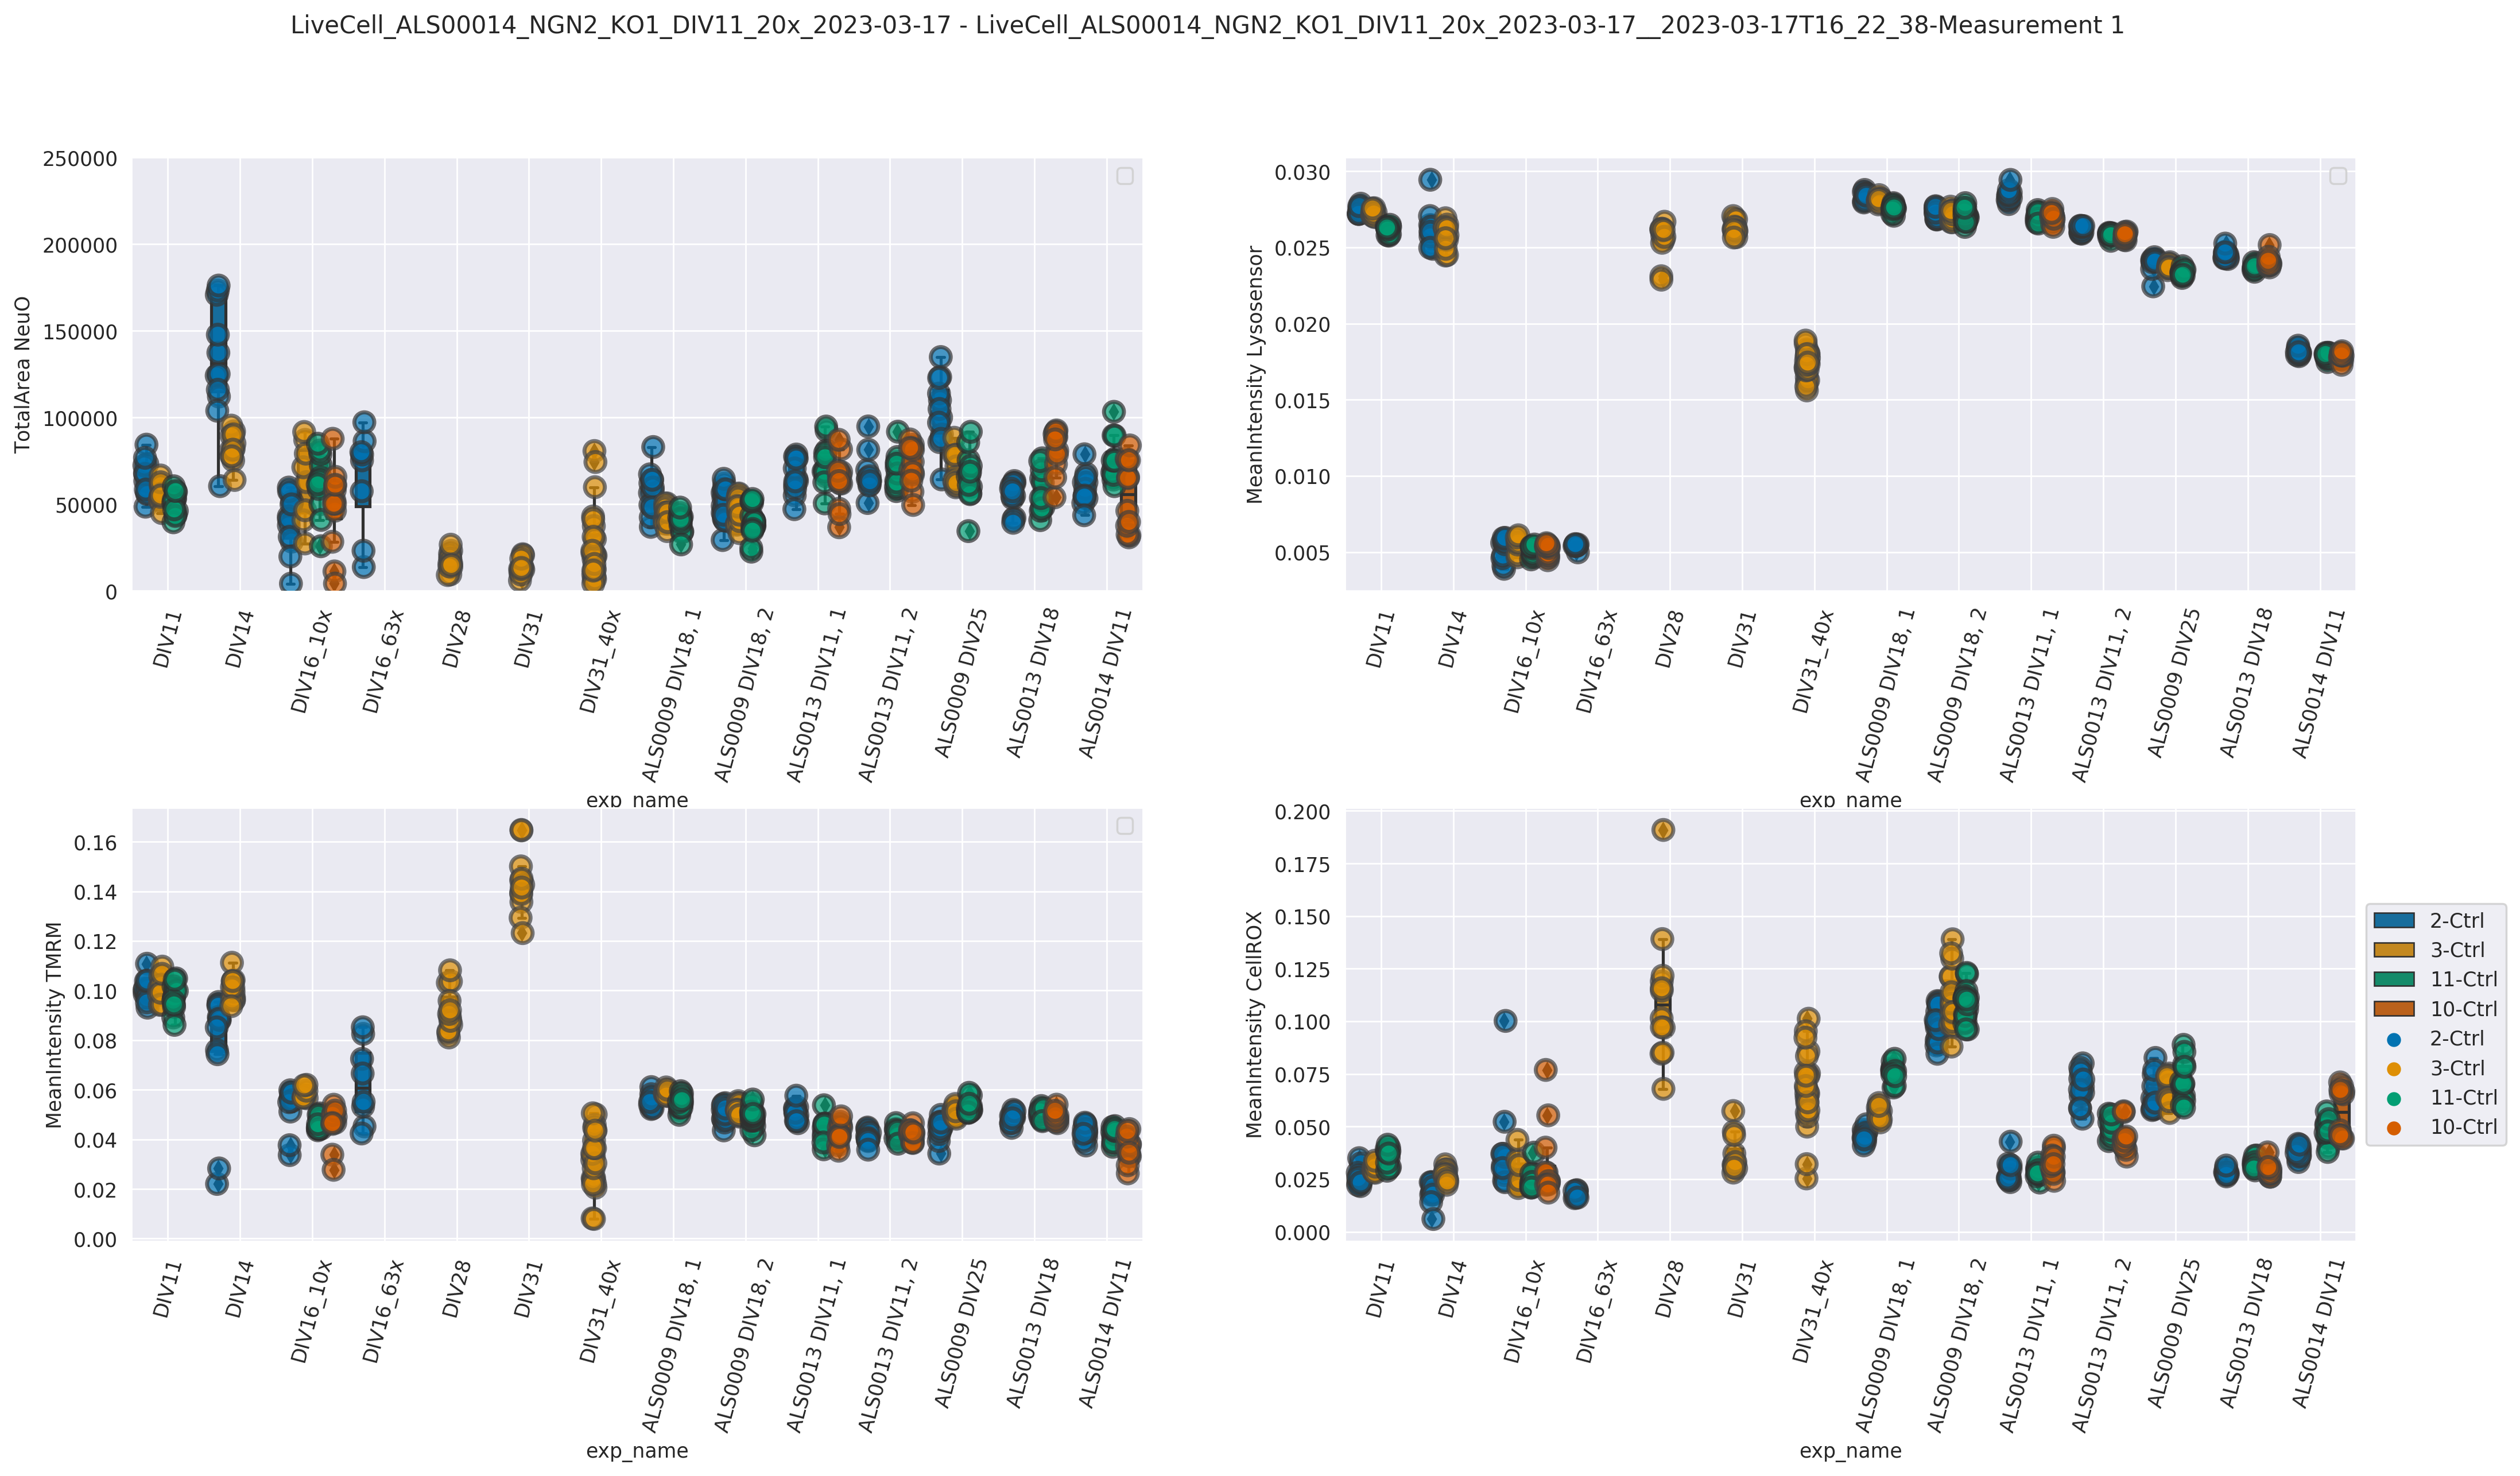

In [15]:
d = []
for exp_name, data_dir in data_dirs.items():
    platemap = pd.read_csv(data_dir / 'platemap.csv')
    data = pd.read_csv(data_dir / '2023-02-28_soma_segment' / '2023-02-28_soma_segment_Image.csv')

    # Set filename and well position
    data['well_position'] = data['FileName_NeuO_pre_illum'].apply(
        lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
    )
    data['row'] = data['FileName_NeuO_pre_illum'].apply(
    lambda fname : int(fname[1:3])
    )
    data['col'] = data['FileName_NeuO_pre_illum'].apply(
        lambda fname : int(fname[4:6])
    )

    data = data.merge(platemap, on='well_position')
    # data = data.groupby(['well_position', 'crispr']).mean()
    data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
    data = data.reset_index()
    measurements = [
        'Intensity_TotalArea_NeuO_masked',
        'Intensity_MeanIntensity_Lysosensor_masked',
        'Intensity_MeanIntensity_TMRM_masked',
        'Intensity_MeanIntensity_CellROX_masked'
    ]
    data['exp_name'] = exp_name
    d.append(data)

data = pd.concat(d, axis=0, ignore_index=True)
data = data.query('crispr == ["No Nucleofection", "Non-Targeting", "No Treatment"]')
data['crispr'] = 'Ctrl'
data['crispr'] = data['col'].astype(str) + '-' + data['crispr']

sns.set_style('darkgrid')
fig, axs = plt.subplots(2,2)

for i_m, m in enumerate(measurements):

    axs_row = floor(i_m/2)
    axs_col = i_m % 2

    sns.boxplot(
        data=data, 
        x='exp_name', 
        # x='concentration',
        y=m, 
        palette='colorblind',
        hue='crispr',
        ax=axs[axs_row, axs_col]
    )
    sns.stripplot(
        data=data, 
        x='exp_name', 
        # x='concentration',
        y=m, 
        palette='colorblind', 
        hue='crispr',
        dodge=True,
        linewidth=2, 
        size=10, 
        alpha=0.7,
        ax=axs[axs_row, axs_col])
    
    axs[axs_row, axs_col].tick_params(axis='x', rotation=75)
    axs[axs_row, axs_col].set_ylabel(m.split('_')[1] + ' ' + m.split('_')[2])
    axs[axs_row, axs_col].xaxis.grid(True)

axs[0, 0].legend('')
axs[0, 1].legend('')
axs[1, 0].legend('')
axs[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0,0].set_ylim([0, 250e3])
plt.suptitle(data_dir.parents[0].name + ' - ' + data_dir.name)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

/tmp/ipykernel_3112/1330171757.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
/tmp/ipykernel_3112/1330171757.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
/tmp/ipykernel_3112/1330171757.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which

DIV11
/lab/processed-data/230303_iN_B5_DIV11_LiveCell/iN_B5_D11_LiveCell_20xH2O__2023-03-03T14_21_01-Measurement 1
ALS0009 DIV18, 1
/lab/processed-data/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18_1__2023-03-10T16_06_08-Measurement 1
ALS0009 DIV18, 2
/lab/processed-data/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18_2__2023-03-10T16_42_11-Measurement 2
ALS0009 DIV25
/lab/processed-data/LiveCell_ALS0009_NGN2_KO1_DIV25_20x_2023-03-17/LiveCell_ALS0009_NGN2_KO1_DIV25_20x_2023__2023-03-17T13_36_52-Measurement 1


0      test
1      test
2      test
3      test
16     test
       ... 
523    test
536    test
537    test
538    test
539    test
Name: exp_name, Length: 216, dtype: object

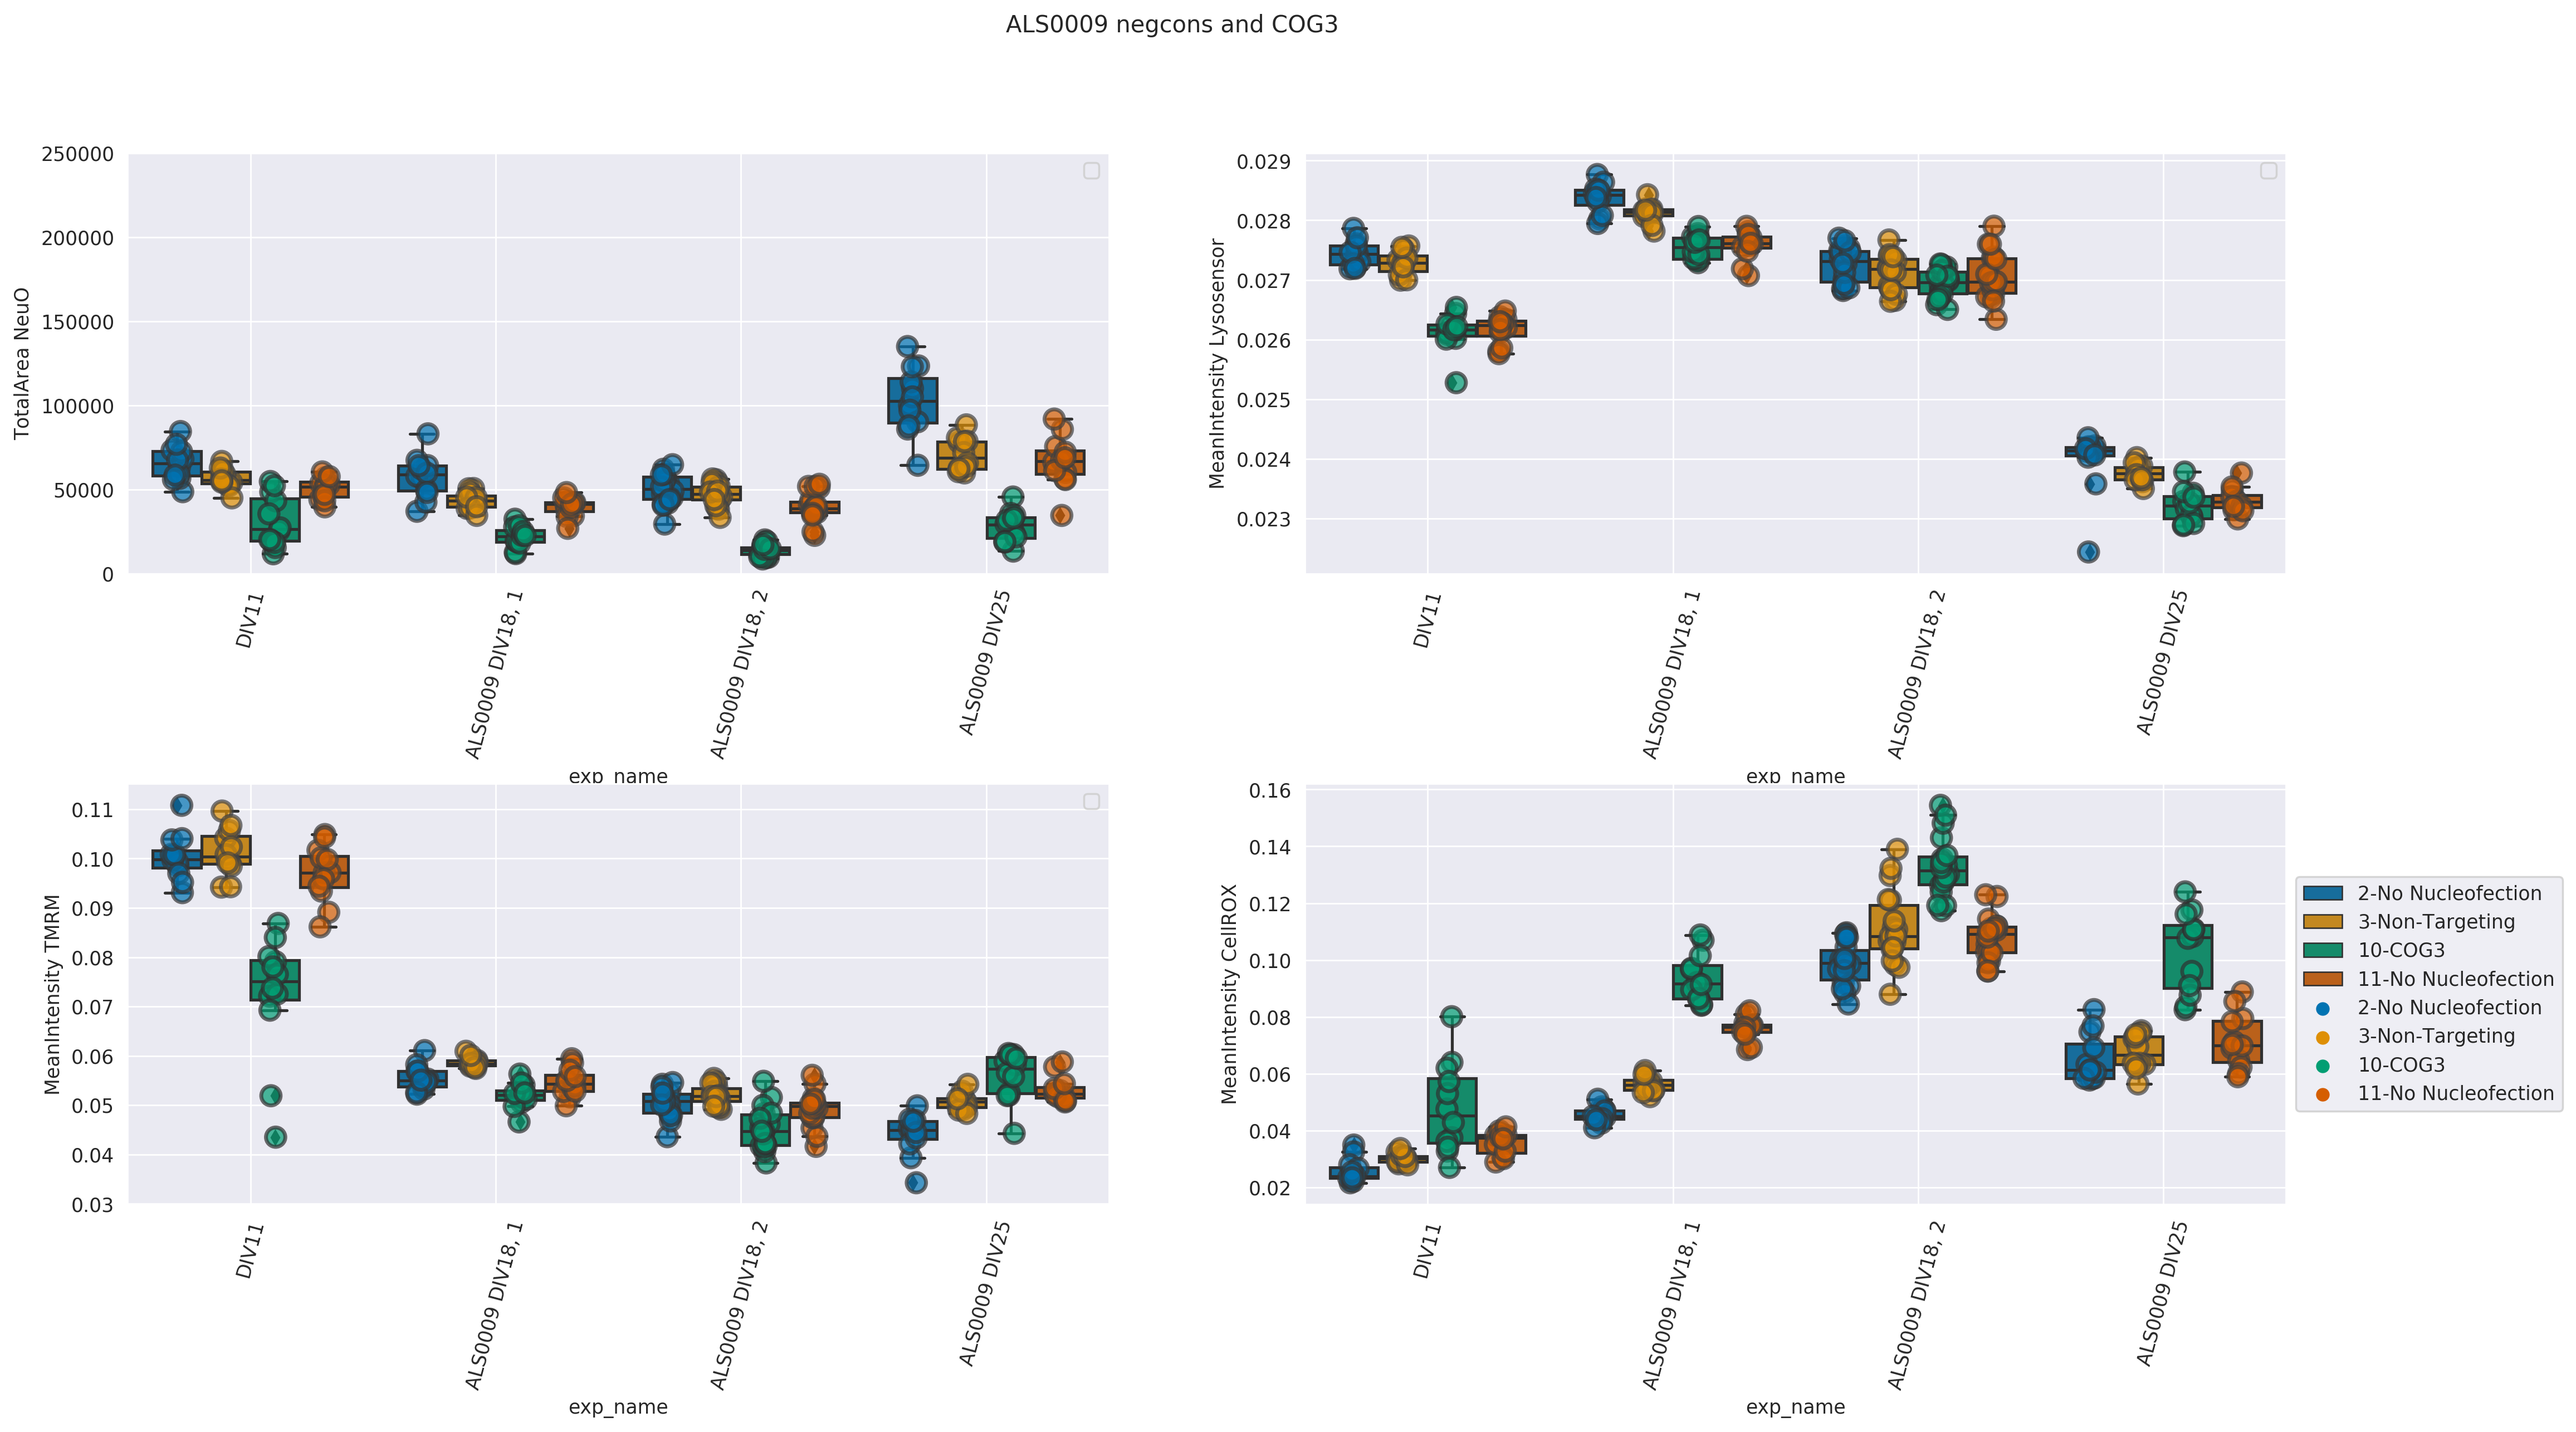

In [9]:


data_dirs = {
    'DIV11' : 
    Path('/lab/processed-data/230303_iN_B5_DIV11_LiveCell/iN_B5_D11_LiveCell_20xH2O__2023-03-03T14_21_01-Measurement 1'),
    'ALS0009 DIV18, 1':
    Path('/lab/processed-data/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18_1__2023-03-10T16_06_08-Measurement 1/'),
    'ALS0009 DIV18, 2':
    Path('/lab/processed-data/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18_2__2023-03-10T16_42_11-Measurement 2/'),
    'ALS0009 DIV25' :
    Path('/lab/processed-data/LiveCell_ALS0009_NGN2_KO1_DIV25_20x_2023-03-17/LiveCell_ALS0009_NGN2_KO1_DIV25_20x_2023__2023-03-17T13_36_52-Measurement 1'),
}
d = []
for exp_name, data_dir in data_dirs.items():
    platemap = pd.read_csv(data_dir / 'platemap.csv')
    data = pd.read_csv(data_dir / '2023-02-28_soma_segment' / '2023-02-28_soma_segment_Image.csv')

    # Set filename and well position
    data['well_position'] = data['FileName_NeuO_pre_illum'].apply(
        lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
    )
    data['row'] = data['FileName_NeuO_pre_illum'].apply(
    lambda fname : int(fname[1:3])
    )
    data['col'] = data['FileName_NeuO_pre_illum'].apply(
        lambda fname : int(fname[4:6])
    )

    data = data.merge(platemap, on='well_position')
    # data = data.groupby(['well_position', 'crispr']).mean()
    data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
    data = data.reset_index()
    measurements = [
        'Intensity_TotalArea_NeuO_masked',
        'Intensity_MeanIntensity_Lysosensor_masked',
        'Intensity_MeanIntensity_TMRM_masked',
        'Intensity_MeanIntensity_CellROX_masked'
    ]
    data['exp_name'] = exp_name
    d.append(data)

data = pd.concat(d, axis=0, ignore_index=True)
data = data.query('crispr == ["No Nucleofection", \
                  "Non-Targeting", \
                  "No Treatment",\
                  "COG3"]')
# data.loc[data['crispr'] == 'No Nucleofection', 'crispr'] = 'Ctrl'
# data.loc[data['crispr'] == 'Non-Targeting', 'crispr'] = 'Ctrl'
# data.loc[data['crispr'] == 'No Treatment', 'crispr'] = 'Ctrl'
data['crispr'] = data['col'].astype(str) + '-' + data['crispr']

sns.set_style('darkgrid')
fig, axs = plt.subplots(2,2)

for i_m, m in enumerate(measurements):

    axs_row = floor(i_m/2)
    axs_col = i_m % 2

    sns.boxplot(
        data=data, 
        x='exp_name', 
        # x='concentration',
        y=m, 
        palette='colorblind',
        hue='crispr',
        ax=axs[axs_row, axs_col]
    )
    sns.stripplot(
        data=data, 
        x='exp_name', 
        # x='concentration',
        y=m, 
        palette='colorblind', 
        hue='crispr',
        dodge=True,
        linewidth=2, 
        size=10, 
        alpha=0.7,
        ax=axs[axs_row, axs_col])
    
    axs[axs_row, axs_col].tick_params(axis='x', rotation=75)
    axs[axs_row, axs_col].set_ylabel(m.split('_')[1] + ' ' + m.split('_')[2])
    axs[axs_row, axs_col].xaxis.grid(True)

axs[0, 0].legend('')
axs[0, 1].legend('')
axs[1, 0].legend('')
axs[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0,0].set_ylim([0, 250e3])
# plt.suptitle('2023-03-19 positive and negatve controls,  experiments')
plt.suptitle('ALS0009 negcons and COG3')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
data['crispr'] == 'No Nucleofection'
[[z, i] for [z, i] in enumerate(data_dirs)]
for x, i in data_dirs.items():
    print(x)
    print(i)
data['exp_name'] = 'test'
data['exp_name']


/tmp/ipykernel_3112/2249035275.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
/tmp/ipykernel_3112/2249035275.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
/tmp/ipykernel_3112/2249035275.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which

DIV11
/lab/processed-data/230303_iN_B5_DIV11_LiveCell/iN_B5_D11_LiveCell_20xH2O__2023-03-03T14_21_01-Measurement 1
DIV14
/lab/processed-data/230227_iN_B4_DIV14_LiveCell/1__2023-02-27T21_03_45-Measurement 4
DIV16_10x
/lab/processed-data/230215_BC_Live/1__2023-02-15T17_25_23-Measurement 2
DIV16_63x
/lab/processed-data/230215_BC_Live/2__2023-02-15T18_09_38-Measurement 1
DIV28
/lab/processed-data/230227_iN_B3_DIV28_LiveCell/1__2023-02-27T21_51_31-Measurement 5
DIV31
/lab/processed-data/230302_iN_B3_DIV31_MG132_LiveCell/iN_B3_DIV31_MG132__2023-03-02T15_25_55-Measurement 1
DIV31_40x
/lab/processed-data/230302_iN_B3_DIV31_MG132_LiveCell/iN_B3_DIV31_MG132_40xH2O__2023-03-02T16_07_40-Measurement 1
ALS0009 DIV18, 1
/lab/processed-data/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18_1__2023-03-10T16_06_08-Measurement 1
ALS0009 DIV18, 2
/lab/processed-data/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18/2023-03-10_LiveCell_20x_ALS0009_KO1_DIV18_2__2023-03-10T16_42_11-

/home/ubuntu/miniconda3/envs/cell-imaging-2/lib/python3.8/site-packages/seaborn/categorical.py:292: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sub_data.loc[:, self.cat_axis] = adjusted_data
/home/ubuntu/miniconda3/envs/cell-imaging-2/lib/python3.8/site-packages/seaborn/categorical.py:292: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sub_data.loc[:, self.cat_axis] = adjusted_data
/home/ubuntu/miniconda3/envs/cell-imaging-2/lib/python3.8/site-packages/seaborn/categorical.py:292: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will att

0       test
1       test
2       test
3       test
18      test
        ... 
1689    test
1704    test
1705    test
1706    test
1707    test
Name: exp_name, Length: 430, dtype: object

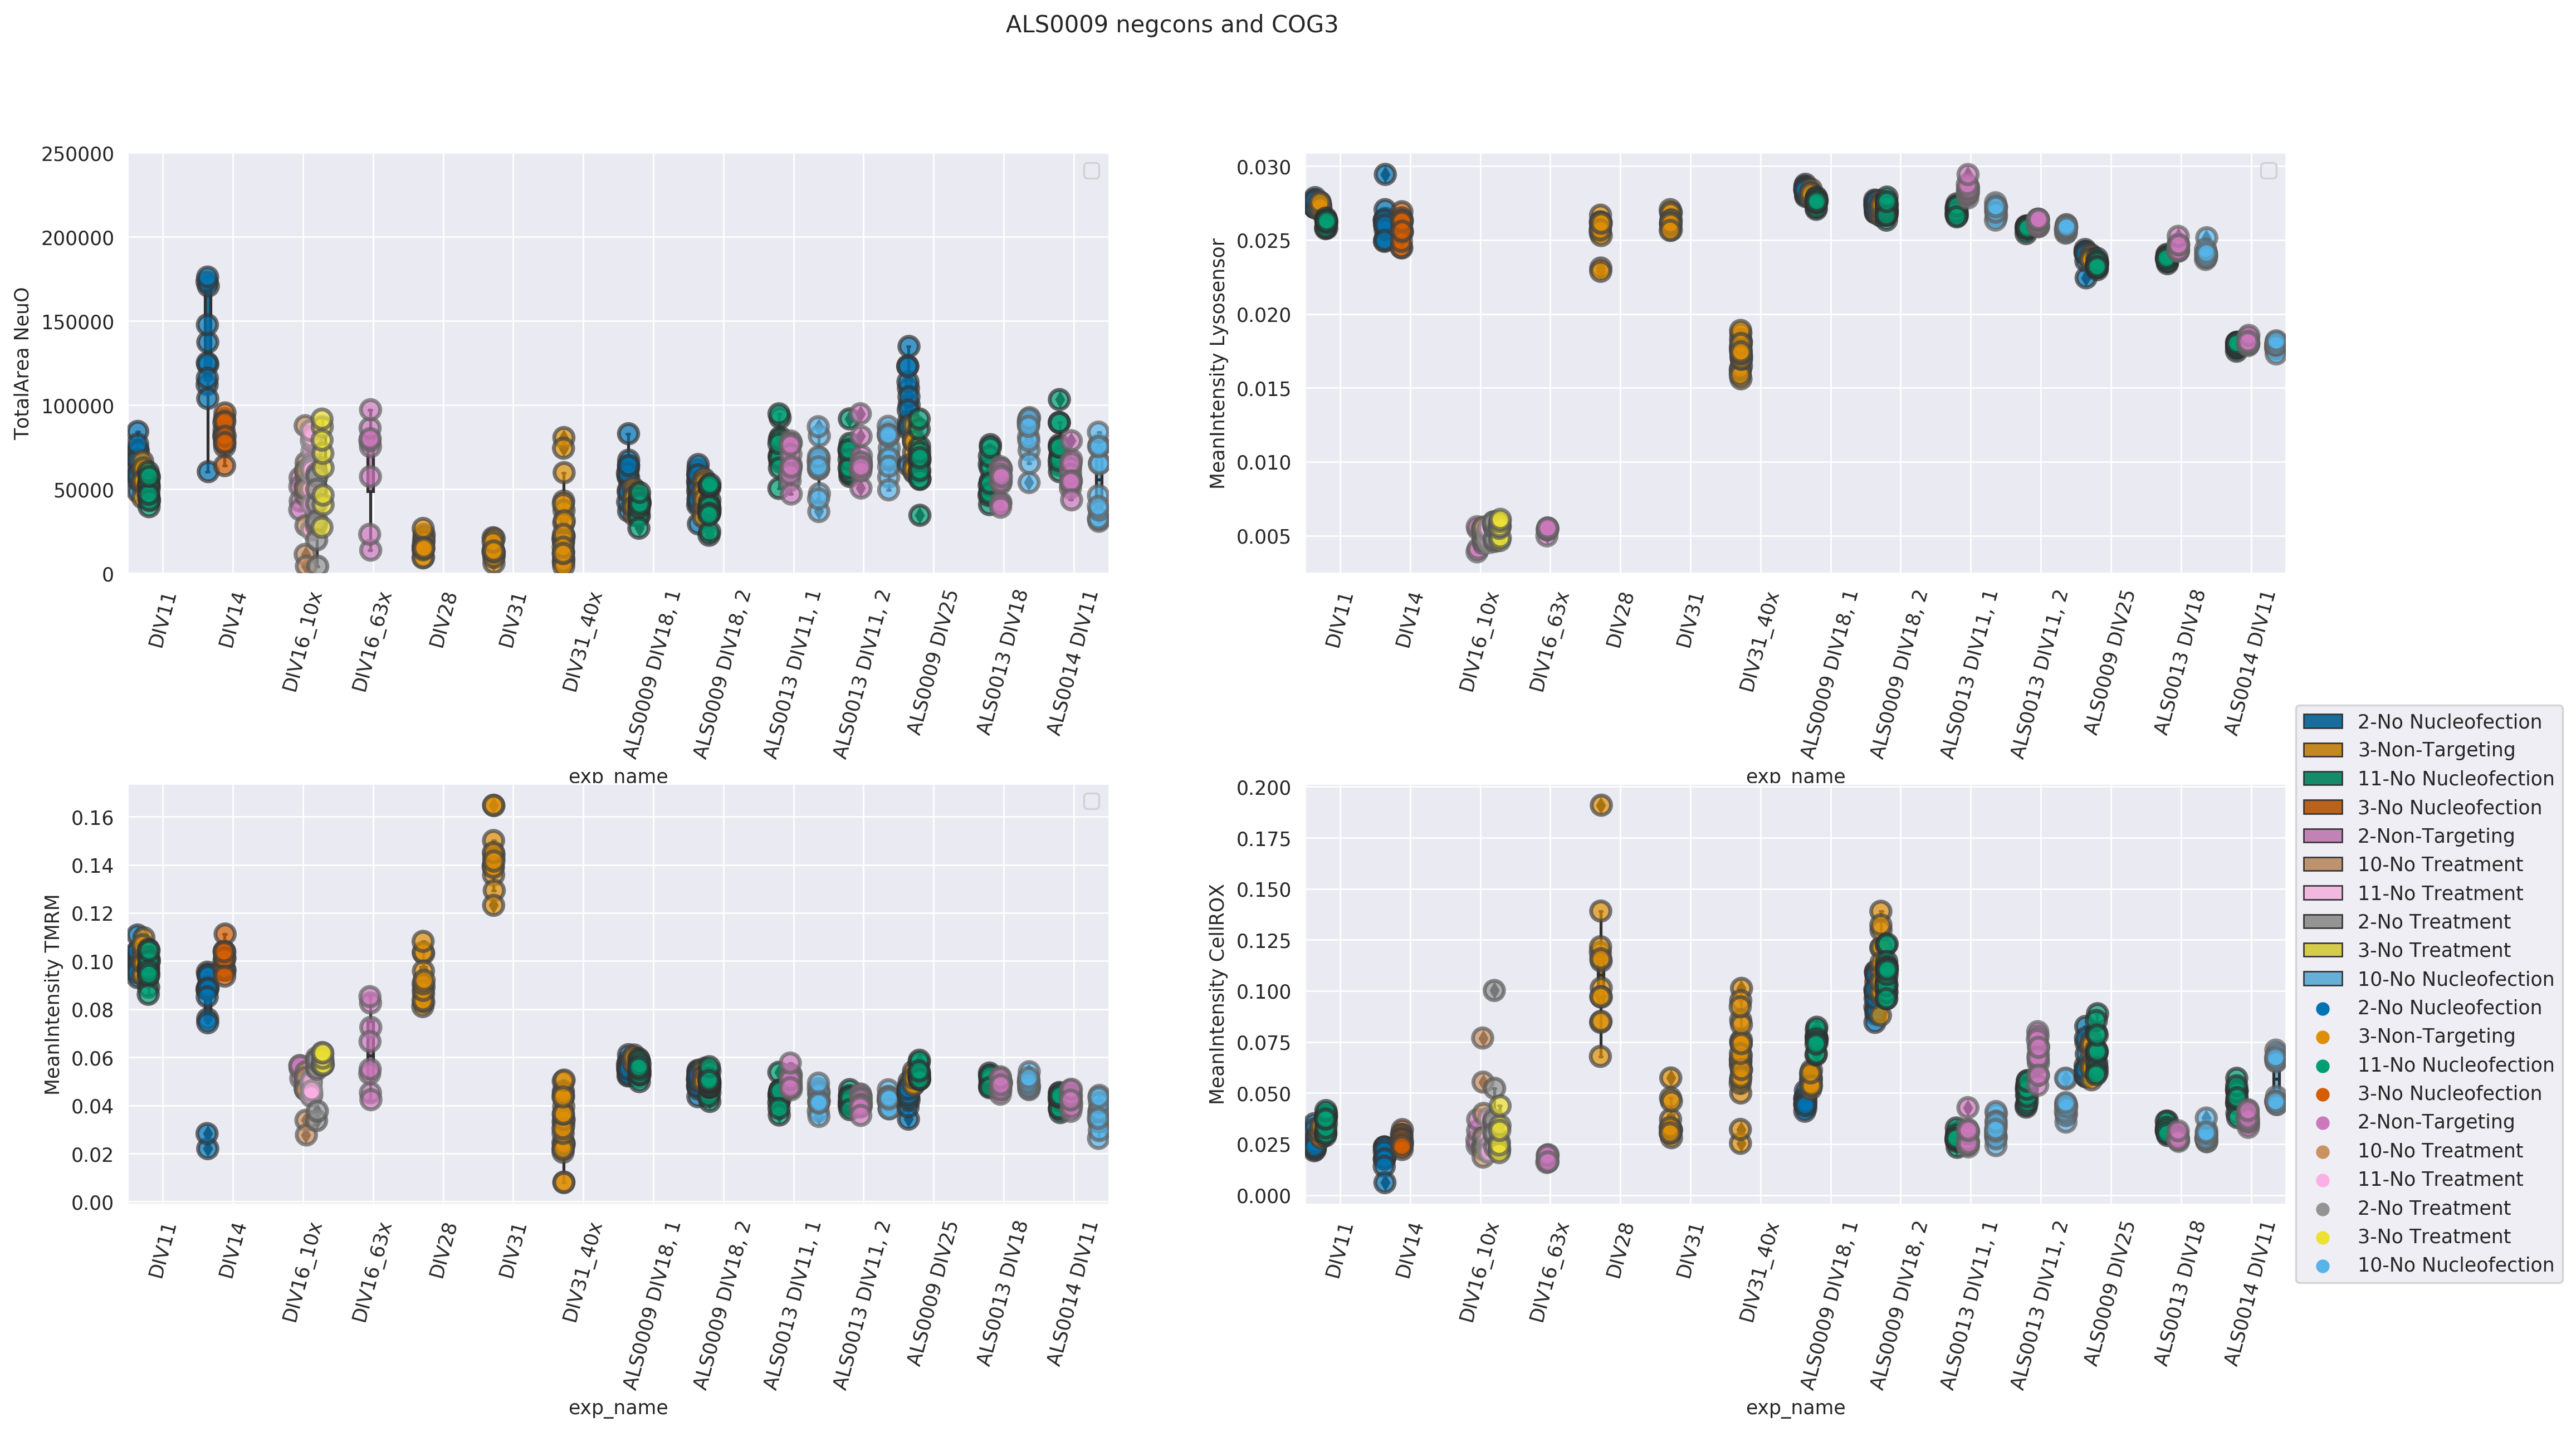

In [12]:
d = []
for exp_name, data_dir in data_dirs.items():
    platemap = pd.read_csv(data_dir / 'platemap.csv')
    data = pd.read_csv(data_dir / '2023-02-28_soma_segment' / '2023-02-28_soma_segment_Image.csv')

    # Set filename and well position
    data['well_position'] = data['FileName_NeuO_pre_illum'].apply(
        lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
    )
    data['row'] = data['FileName_NeuO_pre_illum'].apply(
    lambda fname : int(fname[1:3])
    )
    data['col'] = data['FileName_NeuO_pre_illum'].apply(
        lambda fname : int(fname[4:6])
    )

    data = data.merge(platemap, on='well_position')
    # data = data.groupby(['well_position', 'crispr']).mean()
    data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
    data = data.reset_index()
    measurements = [
        'Intensity_TotalArea_NeuO_masked',
        'Intensity_MeanIntensity_Lysosensor_masked',
        'Intensity_MeanIntensity_TMRM_masked',
        'Intensity_MeanIntensity_CellROX_masked'
    ]
    data['exp_name'] = exp_name
    d.append(data)

data = pd.concat(d, axis=0, ignore_index=True)
data = data.query('crispr == ["No Nucleofection", \
                  "Non-Targeting", \
                  "No Treatment"]')
# data.loc[data['crispr'] == 'No Nucleofection', 'crispr'] = 'Ctrl'
# data.loc[data['crispr'] == 'Non-Targeting', 'crispr'] = 'Ctrl'
# data.loc[data['crispr'] == 'No Treatment', 'crispr'] = 'Ctrl'
data['crispr'] = data['col'].astype(str) + '-' + data['crispr']

sns.set_style('darkgrid')
fig, axs = plt.subplots(2,2)

for i_m, m in enumerate(measurements):

    axs_row = floor(i_m/2)
    axs_col = i_m % 2

    sns.boxplot(
        data=data, 
        x='exp_name', 
        # x='concentration',
        y=m, 
        palette='colorblind',
        hue='crispr',
        ax=axs[axs_row, axs_col]
    )
    sns.stripplot(
        data=data, 
        x='exp_name', 
        # x='concentration',
        y=m, 
        palette='colorblind', 
        hue='crispr',
        dodge=True,
        linewidth=2, 
        size=10, 
        alpha=0.7,
        ax=axs[axs_row, axs_col])
    
    axs[axs_row, axs_col].tick_params(axis='x', rotation=75)
    axs[axs_row, axs_col].set_ylabel(m.split('_')[1] + ' ' + m.split('_')[2])
    axs[axs_row, axs_col].xaxis.grid(True)

axs[0, 0].legend('')
axs[0, 1].legend('')
axs[1, 0].legend('')
axs[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0,0].set_ylim([0, 250e3])
# plt.suptitle('2023-03-19 positive and negatve controls,  experiments')
plt.suptitle('ALS0009 negcons and COG3')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
data['crispr'] == 'No Nucleofection'
[[z, i] for [z, i] in enumerate(data_dirs)]
for x, i in data_dirs.items():
    print(x)
    print(i)
data['exp_name'] = 'test'
data['exp_name']


/tmp/ipykernel_38736/3367330715.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
/tmp/ipykernel_38736/3367330715.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
/tmp/ipykernel_38736/3367330715.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns wh

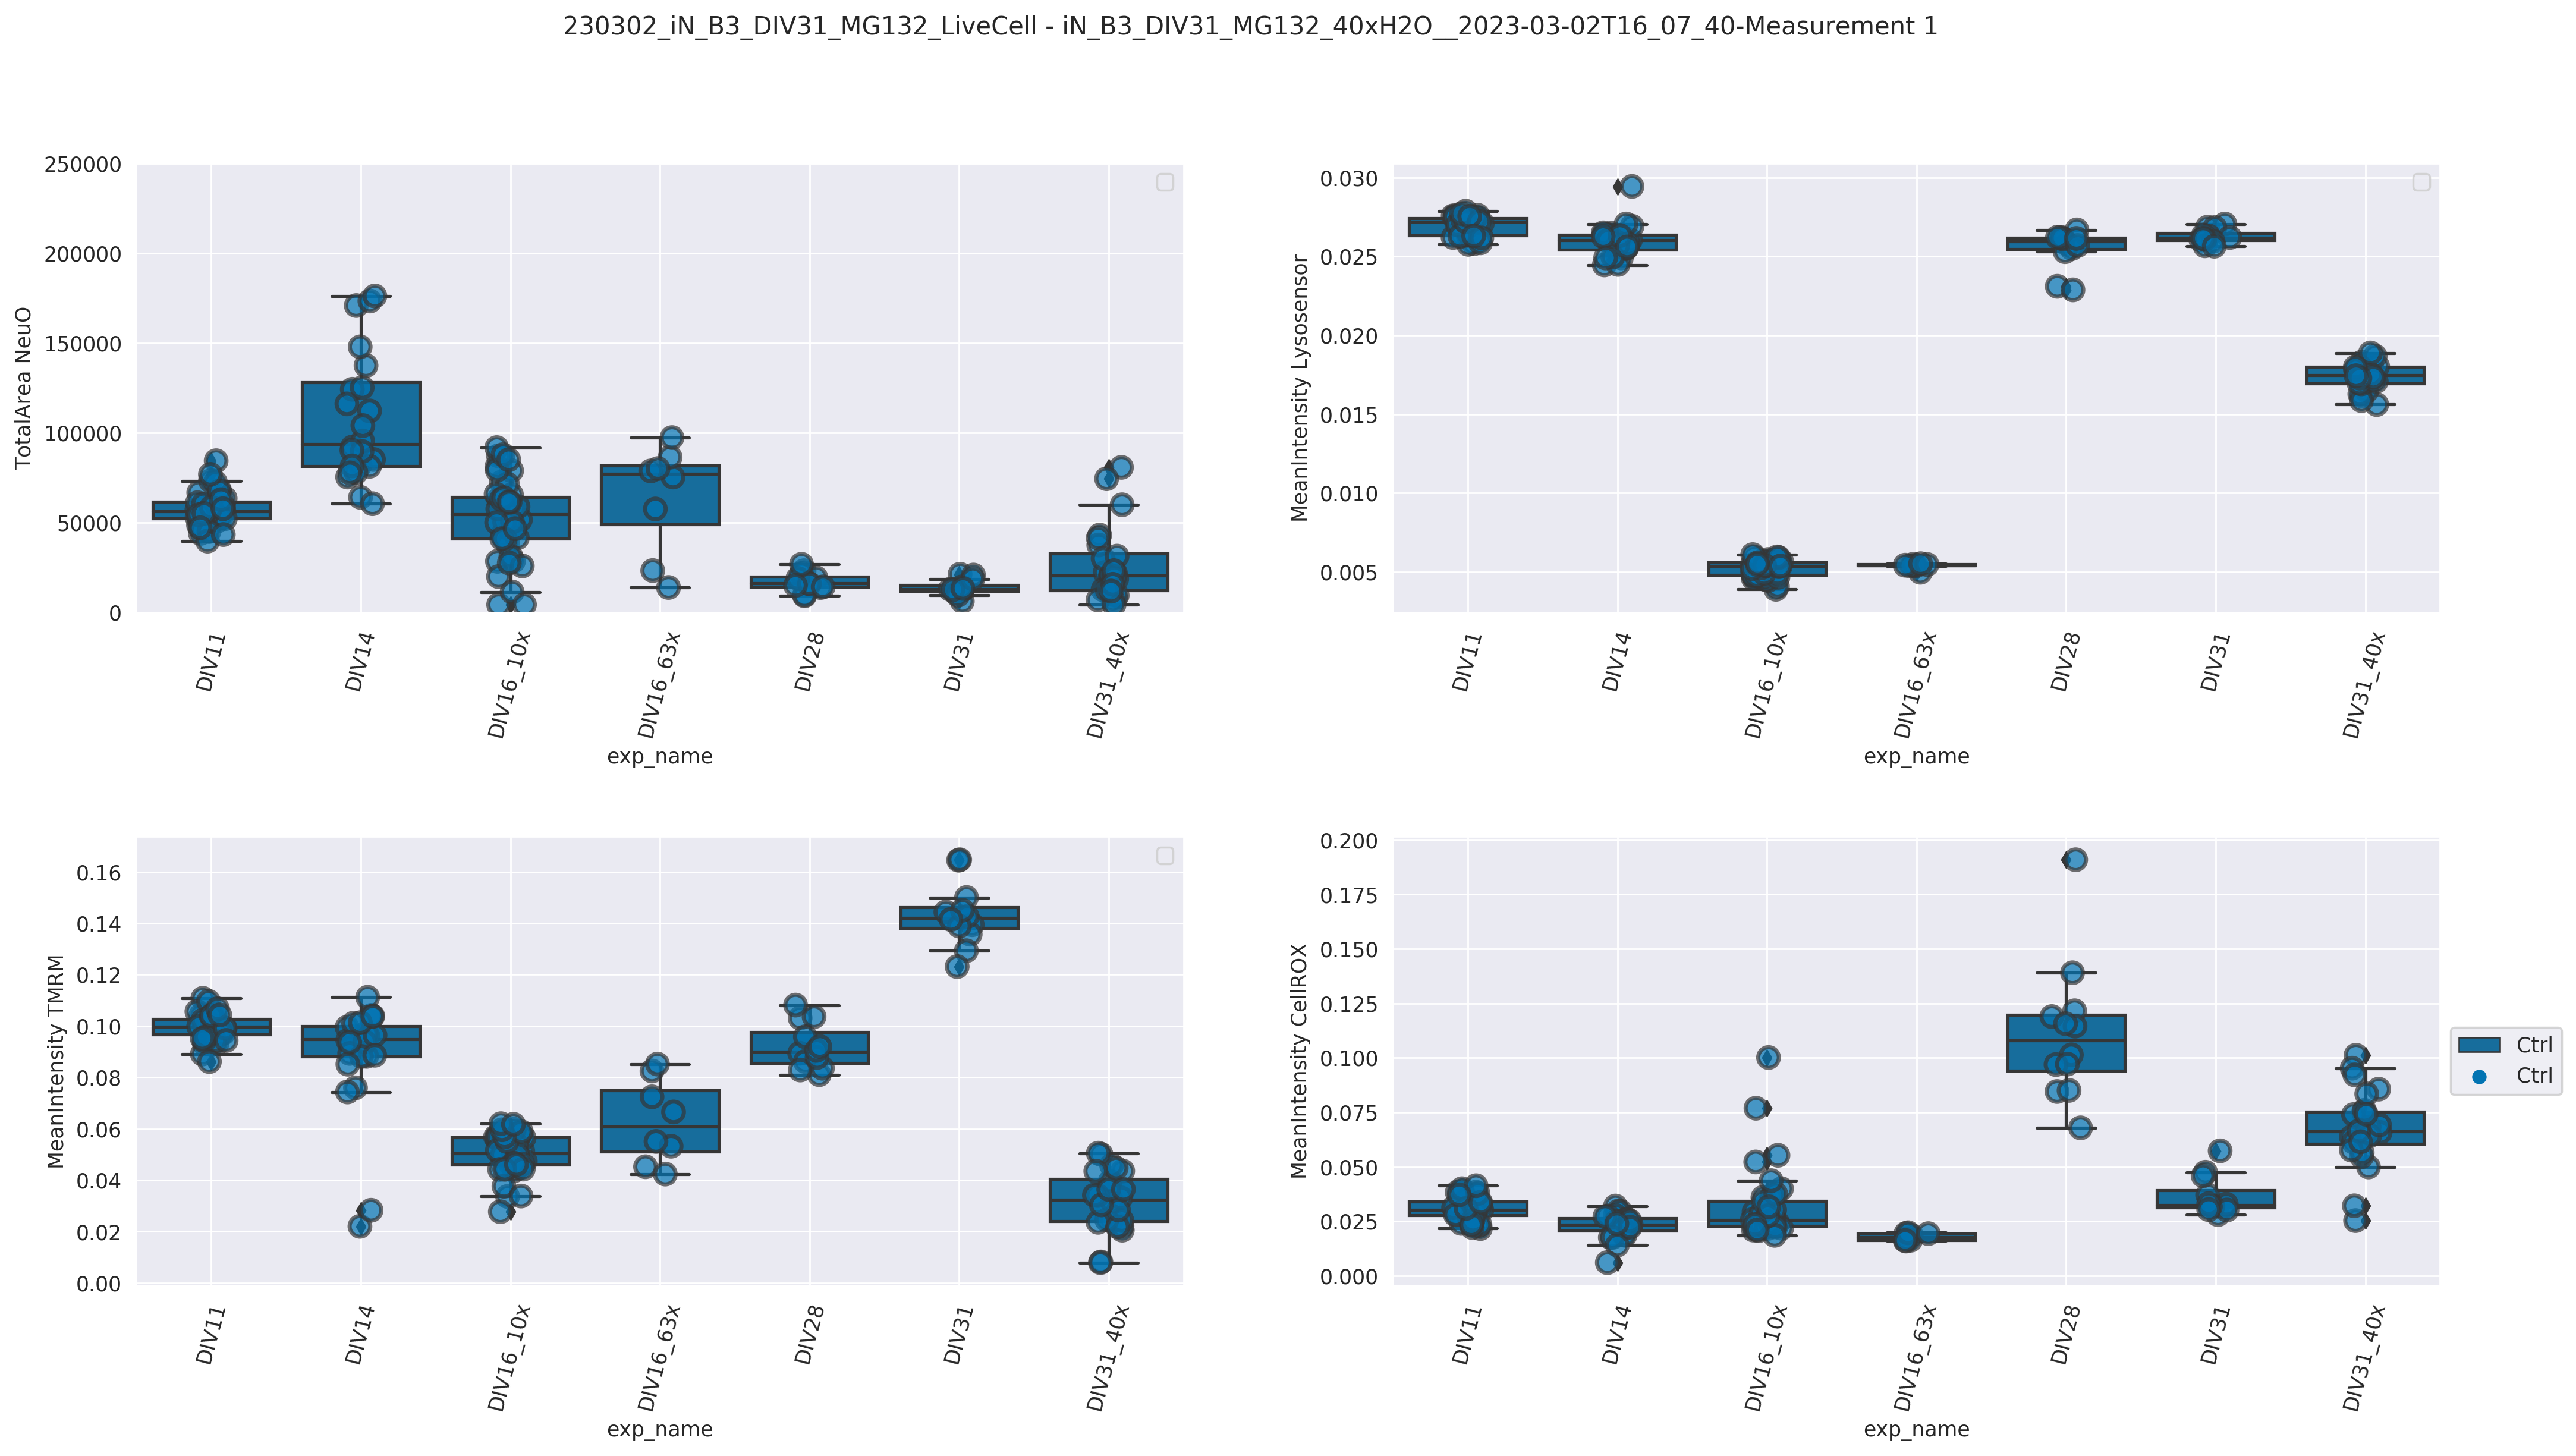

In [15]:
d = []
for exp_name, data_dir in data_dirs.items():
    platemap = pd.read_csv(data_dir / 'platemap.csv')
    data = pd.read_csv(data_dir / '2023-02-28_soma_segment' / '2023-02-28_soma_segment_Image.csv')

    # Set filename and well position
    data['well_position'] = data['FileName_NeuO_pre_illum'].apply(
        lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
    )
    data['row'] = data['FileName_NeuO_pre_illum'].apply(
    lambda fname : int(fname[1:3])
    )
    data['col'] = data['FileName_NeuO_pre_illum'].apply(
        lambda fname : int(fname[4:6])
    )

    data = data.merge(platemap, on='well_position')
    # data = data.groupby(['well_position', 'crispr']).mean()
    data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'col', 'concentration']).mean()
    data = data.reset_index()
    measurements = [
        'Intensity_TotalArea_NeuO_masked',
        'Intensity_MeanIntensity_Lysosensor_masked',
        'Intensity_MeanIntensity_TMRM_masked',
        'Intensity_MeanIntensity_CellROX_masked'
    ]
    data['exp_name'] = exp_name
    d.append(data)

data = pd.concat(d, axis=0, ignore_index=True)
data = data.query('crispr == ["No Nucleofection", \
                  "Non-Targeting", \
                  "No Treatment",\
                  "Nigericin",\
                  "FCCP",\
                  "TBuOOH"]')
data.loc[data['crispr'] == 'No Nucleofection', 'crispr'] = 'Ctrl'
data.loc[data['crispr'] == 'Non-Targeting', 'crispr'] = 'Ctrl'
data.loc[data['crispr'] == 'No Treatment', 'crispr'] = 'Ctrl'
# data['crispr'] = data['col'].astype(str) + '-' + data['crispr']

sns.set_style('darkgrid')
fig, axs = plt.subplots(2,2)

for i_m, m in enumerate(measurements):

    axs_row = floor(i_m/2)
    axs_col = i_m % 2

    sns.boxplot(
        data=data, 
        x='exp_name', 
        # x='concentration',
        y=m, 
        palette='colorblind',
        hue='crispr',
        ax=axs[axs_row, axs_col]
    )
    sns.stripplot(
        data=data, 
        x='exp_name', 
        # x='concentration',
        y=m, 
        palette='colorblind', 
        hue='crispr',
        dodge=True,
        linewidth=2, 
        size=10, 
        alpha=0.7,
        ax=axs[axs_row, axs_col])
    
    axs[axs_row, axs_col].tick_params(axis='x', rotation=75)
    axs[axs_row, axs_col].set_ylabel(m.split('_')[1] + ' ' + m.split('_')[2])
    axs[axs_row, axs_col].xaxis.grid(True)

axs[0, 0].legend('')
axs[0, 1].legend('')
axs[1, 0].legend('')
axs[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0,0].set_ylim([0, 250e3])
plt.suptitle(data_dir.parents[0].name + ' - ' + data_dir.name)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [11]:
data['crispr'] == 'No Nucleofection'

0       True
1       True
2      False
3      False
18      True
       ...  
747    False
776    False
777    False
778    False
779    False
Name: crispr, Length: 160, dtype: bool

In [20]:
[[z, i] for [z, i] in enumerate(data_dirs)]

[[0, 'DIV11'],
 [1, 'DIV14'],
 [2, 'DIV16_10x'],
 [3, 'DIV16_63x'],
 [4, 'DIV28'],
 [5, 'DIV31'],
 [6, 'DIV31_40x']]

In [25]:
for x, i in data_dirs.items():
    print(x)
    print(i)

DIV11
/lab/processed-data/230303_iN_B5_DIV11_LiveCell/iN_B5_D11_LiveCell_20xH2O__2023-03-03T14_21_01-Measurement 1
DIV14
/lab/processed-data/230227_iN_B4_DIV14_LiveCell/1__2023-02-27T21_03_45-Measurement 4
DIV16_10x
/lab/processed-data/230215_BC_Live/1__2023-02-15T17_25_23-Measurement 2
DIV16_63x
/lab/processed-data/230215_BC_Live/2__2023-02-15T18_09_38-Measurement 1
DIV28
/lab/processed-data/230227_iN_B3_DIV28_LiveCell/1__2023-02-27T21_51_31-Measurement 5
DIV31
/lab/processed-data/230302_iN_B3_DIV31_MG132_LiveCell/iN_B3_DIV31_MG132__2023-03-02T15_25_55-Measurement 1
DIV31_40x
/lab/processed-data/230302_iN_B3_DIV31_MG132_LiveCell/iN_B3_DIV31_MG132_40xH2O__2023-03-02T16_07_40-Measurement 1


In [27]:
data['exp_name'] = 'test'
data['exp_name']

0      test
1      test
2      test
3      test
4      test
       ... 
803    test
804    test
805    test
806    test
807    test
Name: exp_name, Length: 808, dtype: object